# IMPACT OF PLANETARY MASS
## Read in results from simulations from MO_main and make figures.

######################################################################################################################

# Initialize notebook; import required functions/packages, and read in input parameters/variables from .txt files.

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from MOparams import *
from MOfunc import *

# Reload the local modules if anything has been changed
%load_ext autoreload
%autoreload 2

In [3]:
# Path to save following simulations to file. -- REPLACE WITH YOUR OWN DIRECTORY IF SAVING

savepath = '/Users/admin/Desktop/FOR_GITHUB/'
savepath.replace("\t","\\t")
savepath.replace("\b","\\b")
savepath.replace("\r","\\r")
savepath.replace("\n","\\n")

'/Users/admin/Desktop/FOR_GITHUB/'

In [4]:
hostfile = 'BHAC15_0.09Msun.txt' # corresponds to M8 host star
HZ_data_file = "HZs_orbits.dat"

star_age, Lbol, Lbol_Ls_star, T_eff_star = hoststar(hostfile)
T_eff_star_45 = np.interp(4.5e9*year, star_age, T_eff_star)
Lbol_Ls_star_45 = np.interp(4.5e9*year, star_age, Lbol_Ls_star)

a_RV, a_RG, a_MG, a_EM = f_a_orb(4.5e9*year, HZ_data_file, hostfile)
    
a_orb_array = np.array([a_RG, (a_RG+a_MG)/2., a_MG])
a_orb_labels = ['Inner', 'Middle', 'Outer']
print(a_orb_labels)

['Inner', 'Middle', 'Outer']


In [5]:
# Initial mass of water in MO, and initial concentration in the MO.
M_init_array = NUM_EARTH_OCEANS*M #np.array([2., 4., 6., 8.])*1.4e21 #[kg]; 1.4e21 kg = 1 Earth Ocean
C_0_array = (3.*M_init_array)/(4.*np.pi*rho*(R_p**3. - R_c**3.))
print(M_init_array/1.4e21, 'Earth Oceans')
print('D =', D)

[2. 4. 6. 8.] Earth Oceans
D = 0.001


# Read in the simulation results from files. 

In [6]:
# Read in MO results (pre-cycling).

save_path = savepath

#tolerance = 1.29e16 #[kg]; if below this, set water = 0 --> DESICCATED

# Initial water content in each reservoir
M_MO_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_SM_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_atmo_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))

# Final water content in each reservoir
M_MO_final_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_SM_final_all = np.zeros((len(M_init_array), len(a_orb_array)))
M_atmo_final_all = np.zeros((len(M_init_array), len(a_orb_array)))

# Initial and final mantle temperatures, if needed.
T_MO_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
T_MO_final_all = np.zeros((len(M_init_array), len(a_orb_array)))

# How many reach exactly zero in one/both reservoir/s at the end?
#W_m_zero_count_MO_all = 0.
#W_s_zero_count_MO_all = 0.
#both_zero_count_MO_all = 0.

for jdx in range(0, len(a_orb_array)):
    
    # Need length of data for the following arrays.
    save_file = f'MOresults_{int(M/M_E)}_earth_mass_D_of_{D}_' + str(np.int(NUM_EARTH_OCEANS_FILE[0])) + '_oceans_' + a_orb_labels[jdx] + '_hz.txt'
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)

    # Time array; same for all with the same orbital distance.
    t_MO_array = tmp_data[:, 0]

    # Overall evolution path for each reservoir & mantle temperature & surface temperature.
    M_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    M_SM_paths = np.zeros((len(M_init_array),len(tmp_data)))
    M_atmo_paths = np.zeros((len(M_init_array),len(tmp_data)))
    r_sol_paths = np.zeros((len(M_init_array),len(tmp_data)))
    T_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    TOA_flux_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    #TOA_flux_paths = np.zeros((len(tau_MO_array), len(M_init_array),len(tmp_data)))

    # Overall evolution path for degassing and regassing rates.
    loss_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    EL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    DL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    
    for kdx in range(0, len(M_init_array)):
                
        # Read in data files for each model, and save them as the evolutionary path. 
        save_file = save_file = f'MOresults_{int(M/M_E)}_earth_mass_D_of_{D}_' + str(np.int(NUM_EARTH_OCEANS_FILE[kdx])) + '_oceans_' + a_orb_labels[jdx] + '_hz.txt'
            
        print(save_file)
        filename = os.path.join(save_path, save_file)
        tmp_data = np.loadtxt(filename)
        r_sol_paths[kdx,:] = tmp_data[:,1]
        T_MO_paths[kdx:] = tmp_data[:,2]
        M_MO_paths[kdx,:] = tmp_data[:,3]
        M_SM_paths[kdx,:] = tmp_data[:,4]
        M_atmo_paths[kdx,:] = tmp_data[:,5]
        EL_MO_paths[kdx,:] = tmp_data[:,6]
        DL_MO_paths[kdx,:] = tmp_data[:,7]
        loss_MO_paths[kdx,:] = tmp_data[:,8]
        TOA_flux_MO_paths[kdx,:] = tmp_data[:,9]

        # Save initial and final values to corresponding arrays.
        M_MO_initial_all[kdx, jdx] = M_MO_paths[kdx,0]
        M_SM_initial_all[kdx, jdx] = M_SM_paths[kdx,0]
        M_atmo_initial_all[kdx, jdx] = M_atmo_paths[kdx,0]
    
        T_MO_initial_all[kdx, jdx] = T_MO_paths[kdx,0]
        T_MO_final_all[kdx, jdx] = T_MO_paths[kdx,-1]
        
        M_MO_final_all[kdx, jdx] = M_MO_paths[kdx,-1]
        M_SM_final_all[kdx, jdx] = M_SM_paths[kdx,-1]     
        M_atmo_final_all[kdx, jdx] = M_atmo_paths[kdx,-1]

MOresults_1_earth_mass_D_of_0.001_2_oceans_Inner_hz.txt
MOresults_1_earth_mass_D_of_0.001_4_oceans_Inner_hz.txt
MOresults_1_earth_mass_D_of_0.001_6_oceans_Inner_hz.txt
MOresults_1_earth_mass_D_of_0.001_8_oceans_Inner_hz.txt
MOresults_1_earth_mass_D_of_0.001_2_oceans_Middle_hz.txt
MOresults_1_earth_mass_D_of_0.001_4_oceans_Middle_hz.txt
MOresults_1_earth_mass_D_of_0.001_6_oceans_Middle_hz.txt
MOresults_1_earth_mass_D_of_0.001_8_oceans_Middle_hz.txt
MOresults_1_earth_mass_D_of_0.001_2_oceans_Outer_hz.txt
MOresults_1_earth_mass_D_of_0.001_4_oceans_Outer_hz.txt
MOresults_1_earth_mass_D_of_0.001_6_oceans_Outer_hz.txt
MOresults_1_earth_mass_D_of_0.001_8_oceans_Outer_hz.txt


In [7]:
## Read in cycling results (post-MO).

save_path = savepath
tolerance = 1.29e16 #[kg]; if below this, set water = 0 --> DESICCATED

# Initial water content in each reservoir
W_m_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
W_s_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))

# Final water content in each reservoir
W_m_final_all = np.zeros((len(M_init_array), len(a_orb_array)))
W_s_final_all = np.zeros((len(M_init_array), len(a_orb_array)))

# Initial and final mantle temperatures, if needed.
T_initial_all = np.zeros((len(M_init_array), len(a_orb_array)))
T_final_all = np.zeros((len(M_init_array), len(a_orb_array)))

# How many reach exactly zero in one/both reservoir/s at the end?
W_m_zero_count_all = 0.
W_s_zero_count_all = 0.
both_zero_count_all = 0.

for jdx in range(0, len(a_orb_array)):
    
    # Need length of data for the following arrays.
    save_file = f'cyclingresults_{int(M/M_E)}_earth_mass_D_of_{D}_' + str(np.int(NUM_EARTH_OCEANS_FILE[0])) + '_oceans_' + a_orb_labels[jdx] + '_hz.txt'    
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)

    # Time array; same for all.
    t_array = tmp_data[:, 0]

    # Overall evolution path for each reservoir & mantle temperature & surface temperature.
    W_m_paths = np.zeros((len(M_init_array),len(tmp_data)))
    W_s_paths = np.zeros((len(M_init_array),len(tmp_data)))
    T_paths = np.zeros((len(M_init_array),len(tmp_data)))
    T_surf_paths = np.zeros((len(M_init_array),len(tmp_data)))
    TOA_flux_paths = np.zeros((len(M_init_array),len(tmp_data)))
    #TOA_flux_paths = np.zeros((len(tau_MO_array), len(M_init_array),len(tmp_data)))

    # Overall evolution path for degassing and regassing rates.
    degas_paths = np.zeros((len(M_init_array),len(tmp_data)))
    regas_paths = np.zeros((len(M_init_array),len(tmp_data)))
    loss_paths = np.zeros((len(M_init_array),len(tmp_data)))
    EL_paths = np.zeros((len(M_init_array),len(tmp_data)))
    DL_paths = np.zeros((len(M_init_array),len(tmp_data)))
    
    for kdx in range(0, len(M_init_array)):
        
        # Read in data files for each model, and save them as the evolutionary path. 
        save_file = f'cyclingresults_{int(M/M_E)}_earth_mass_D_of_{D}_' + str(np.int(NUM_EARTH_OCEANS_FILE[kdx])) + '_oceans_' + a_orb_labels[jdx] + '_hz.txt'        
        print(save_file)
        filename = os.path.join(save_path, save_file)
        tmp_data = np.loadtxt(filename)
        T_paths[kdx,:] = tmp_data[:,1]
        W_m_paths[kdx,:] = tmp_data[:,2]
        W_s_paths[kdx,:] = tmp_data[:,3]
        degas_paths[kdx,:] = tmp_data[:,4]
        regas_paths[kdx,:] = tmp_data[:,5]
        T_surf_paths[kdx,:] = tmp_data[:,6]
        TOA_flux_paths[kdx,:] = tmp_data[:,8]
        loss_paths[kdx,:] = tmp_data[:,9]
        EL_paths[kdx,:] = tmp_data[:,10]
        DL_paths[kdx,:] = tmp_data[:,11]
        #DL_paths[jdx,kdx,:] = tmp_data[:,11]

        # Save initial and final values to corresponding arrays.
        W_m_initial_all[kdx, jdx] = W_m_paths[kdx,0]
        W_s_initial_all[kdx, jdx] = W_s_paths[kdx,0]
    
        T_initial_all[kdx, jdx] = T_paths[kdx,0]
        T_final_all[kdx, jdx] = T_paths[kdx,-1]
    
        # Check for zeros.     
        if W_m_paths[kdx,-1] <= tolerance and W_s_paths[kdx,-1] <= tolerance:
            both_zero_count_all = both_zero_count_all + 1.
            #W_m_final[jdx,kdx] = 0.
            #W_s_final[jdx,kdx] = 0.
        elif W_m_paths[kdx,-1] <= tolerance:
            W_m_zero_count_all = W_m_zero_count_all + 1.
            #W_m_final[jdx,kdx] = 0.
            #W_s_final[jdx,kdx] = W_s_paths[jdx,kdx,-1]
        elif W_s_paths[kdx,-1] <= tolerance:
            W_s_zero_count_all = W_s_zero_count_all + 1.
            #W_s_final[jdx,kdx] = 0.
            #W_m_final[jdx,kdx] = W_m_paths[jdx,kdx,-1]
        else: #neither is zero; save normally
            W_m_final_all[kdx, jdx] = W_m_paths[kdx,-1]
            W_s_final_all[kdx, jdx] = W_s_paths[kdx,-1]
        
        W_m_final_all[kdx, jdx] = W_m_paths[kdx,-1]
        W_s_final_all[kdx, jdx] = W_s_paths[kdx,-1]      
            
print('Zero water: ', 'W_m: ', W_m_zero_count_all, 'W_s: ', W_s_zero_count_all, 'both: ', both_zero_count_all)

cyclingresults_1_earth_mass_D_of_0.001_2_oceans_Inner_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_4_oceans_Inner_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_6_oceans_Inner_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_8_oceans_Inner_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_2_oceans_Middle_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_4_oceans_Middle_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_6_oceans_Middle_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_8_oceans_Middle_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_2_oceans_Outer_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_4_oceans_Outer_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_6_oceans_Outer_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_8_oceans_Outer_hz.txt
Zero water:  W_m:  0.0 W_s:  3.0 both:  0.0


### Individual read-ins for a given orbital distance.

In [8]:
# Choose which orbital distance will be read-in.
orb_idx = 1 #0-2
print(a_orb_labels[orb_idx])

Middle


In [9]:
# Read in MO results (pre-cycling).

#save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'
save_path = savepath

# Initial water content in each reservoir
M_MO_initial = np.zeros(len(M_init_array))
M_SM_initial = np.zeros(len(M_init_array))
M_atmo_initial = np.zeros(len(M_init_array))

# Final water content in each reservoir
M_MO_final = np.zeros(len(M_init_array))
M_SM_final = np.zeros(len(M_init_array))
M_atmo_final = np.zeros(len(M_init_array))

# Initial and final mantle temperatures, if needed.
T_MO_initial = np.zeros(len(M_init_array))
T_MO_final = np.zeros(len(M_init_array))
    
# Need length of data for the following arrays.
save_file = f'MOresults_{int(M/M_E)}_earth_mass_D_of_{D}_' + str(np.int(NUM_EARTH_OCEANS_FILE[0])) + '_oceans_' + a_orb_labels[orb_idx] + '_hz.txt'
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array; same for all.
t_MO_array = tmp_data[:, 0]

# Overall evolution path for each reservoir & mantle temperature & surface temperature.
M_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
M_SM_paths = np.zeros((len(M_init_array),len(tmp_data)))
M_atmo_paths = np.zeros((len(M_init_array),len(tmp_data)))
r_sol_paths = np.zeros((len(M_init_array),len(tmp_data)))
T_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
TOA_flux_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))

loss_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
EL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
DL_MO_paths = np.zeros((len(M_init_array),len(tmp_data)))
    
for kdx in range(0, len(M_init_array)):
                
    # Read in data files for each model, and save them as the evolutionary path.  
    save_file = f'MOresults_{int(M/M_E)}_earth_mass_D_of_{D}_'  + str(np.int(NUM_EARTH_OCEANS_FILE[kdx])) + '_oceans_' + a_orb_labels[orb_idx] + '_hz.txt'
            
    print(save_file)
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    r_sol_paths[kdx,:] = tmp_data[:,1]
    T_MO_paths[kdx,:] = tmp_data[:,2]
    M_MO_paths[kdx,:] = tmp_data[:,3]
    M_SM_paths[kdx,:] = tmp_data[:,4]
    M_atmo_paths[kdx,:] = tmp_data[:,5]
    EL_MO_paths[kdx,:] = tmp_data[:,6]
    DL_MO_paths[kdx,:] = tmp_data[:,7]
    loss_MO_paths[kdx,:] = tmp_data[:,8]
    TOA_flux_MO_paths[kdx,:] = tmp_data[:,9]

    # Save initial and final values to corresponding arrays.
    M_MO_initial[kdx] = M_MO_paths[kdx,0]
    M_SM_initial[kdx] = M_SM_paths[kdx,0]
    M_atmo_initial[kdx] = M_atmo_paths[kdx,0]
    
    T_MO_initial[kdx] = T_MO_paths[kdx,0]
    T_MO_final[kdx] = T_MO_paths[kdx,-1]
        
    M_MO_final[kdx] = M_MO_paths[kdx,-1]
    M_SM_final[kdx] = M_SM_paths[kdx,-1]     
    M_atmo_final[kdx] = M_atmo_paths[kdx,-1]

MOresults_1_earth_mass_D_of_0.001_2_oceans_Middle_hz.txt
MOresults_1_earth_mass_D_of_0.001_4_oceans_Middle_hz.txt
MOresults_1_earth_mass_D_of_0.001_6_oceans_Middle_hz.txt
MOresults_1_earth_mass_D_of_0.001_8_oceans_Middle_hz.txt


In [10]:
#Read in cycling files (post-MO). 

#save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'
save_path = savepath

tolerance = 1.29e16 #[kg]; if below this, set water = 0 --> DESICCATED

# Initial water content in each reservoir
W_m_initial = np.zeros(len(M_init_array))
W_s_initial = np.zeros(len(M_init_array))

# Final water content in each reservoir
W_m_final = np.zeros(len(M_init_array))
W_s_final = np.zeros(len(M_init_array))

# Initial and final mantle temperatures, if needed.
T_initial = np.zeros(len(M_init_array))
T_final = np.zeros(len(M_init_array))

# How many reach exactly zero in one/both reservoir/s at the end?
W_m_zero_count = 0.
W_s_zero_count = 0.
both_zero_count = 0.
    
# Need length of data for the following arrays.
save_file = f'cyclingresults_{int(M/M_E)}_earth_mass_D_of_{D}_'  + str(np.int(NUM_EARTH_OCEANS_FILE[0])) + '_oceans_' + a_orb_labels[orb_idx] + '_hz.txt'   
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array; same for all.
t_array = tmp_data[:, 0]

# Overall evolution path for each reservoir & mantle temperature & surface temperature.
W_m_paths = np.zeros((len(M_init_array),len(tmp_data)))
W_s_paths = np.zeros((len(M_init_array),len(tmp_data)))
T_paths = np.zeros((len(M_init_array),len(tmp_data)))
T_surf_paths = np.zeros((len(M_init_array),len(tmp_data)))
TOA_flux_paths = np.zeros((len(M_init_array),len(tmp_data)))

# Overall evolution path for degassing and regassing rates.
degas_paths = np.zeros((len(M_init_array),len(tmp_data)))
regas_paths = np.zeros((len(M_init_array),len(tmp_data)))
loss_paths = np.zeros((len(M_init_array),len(tmp_data)))
EL_paths = np.zeros((len(M_init_array),len(tmp_data)))
DL_paths = np.zeros((len(M_init_array),len(tmp_data)))
    
for kdx in range(0, len(M_init_array)):
                
    # Read in data files for each model, and save them as the evolutionary path.  
    save_file = f'cyclingresults_{int(M/M_E)}_earth_mass_D_of_{D}_'  + str(np.int(NUM_EARTH_OCEANS_FILE[kdx])) + '_oceans_' + a_orb_labels[orb_idx] + '_hz.txt'
            
    print(save_file)
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_paths[kdx,:] = tmp_data[:,1]
    W_m_paths[kdx,:] = tmp_data[:,2]
    W_s_paths[kdx,:] = tmp_data[:,3]
    degas_paths[kdx,:] = tmp_data[:,4]
    regas_paths[kdx,:] = tmp_data[:,5]
    T_surf_paths[kdx,:] = tmp_data[:,6]
    TOA_flux_paths[kdx,:] = tmp_data[:,8]
    loss_paths[kdx,:] = tmp_data[:,9]
    EL_paths[kdx,:] = tmp_data[:,10]
    DL_paths[kdx,:] = tmp_data[:,11]
    #DL_paths[jdx,kdx,:] = tmp_data[:,11]

    # Save initial and final values to corresponding arrays.
    W_m_initial[kdx] = W_m_paths[kdx,0]
    W_s_initial[kdx] = W_s_paths[kdx,0]
    
    T_initial[kdx] = T_paths[kdx,0]
    T_final[kdx] = T_paths[kdx,-1]
    
    # Check for zeros.     
    if W_m_paths[kdx,-1] <= tolerance and W_s_paths[kdx,-1] <= tolerance:
        both_zero_count = both_zero_count + 1.
        #W_m_final[jdx,kdx] = 0.
        #W_s_final[jdx,kdx] = 0.
    elif W_m_paths[kdx,-1] <= tolerance:
        W_m_zero_count = W_m_zero_count + 1.
        #W_m_final[jdx,kdx] = 0.
        #W_s_final[jdx,kdx] = W_s_paths[jdx,kdx,-1]
    elif W_s_paths[kdx,-1] <= tolerance:
        W_s_zero_count = W_s_zero_count + 1.
        #W_s_final[jdx,kdx] = 0.
        #W_m_final[jdx,kdx] = W_m_paths[jdx,kdx,-1]
    else: #neither is zero; save normally
        W_m_final[kdx] = W_m_paths[kdx,-1]
        W_s_final[kdx] = W_s_paths[kdx,-1]
        
    W_m_final[kdx] = W_m_paths[kdx,-1]
    W_s_final[kdx] = W_s_paths[kdx,-1]      
            
print('Zero water: ', 'W_m: ', W_m_zero_count, 'W_s: ', W_s_zero_count, 'both: ', both_zero_count)

cyclingresults_1_earth_mass_D_of_0.001_2_oceans_Middle_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_4_oceans_Middle_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_6_oceans_Middle_hz.txt
cyclingresults_1_earth_mass_D_of_0.001_8_oceans_Middle_hz.txt
Zero water:  W_m:  0.0 W_s:  1.0 both:  0.0


## Plot all results.

# Make a temporal plot (for an individual result for now):
# MO, linear in time, scaled to solidification timescale, on left
# Cycling, log time, on right

In [11]:
init_idx = 0 #0-3; initial surface water: {0.00047, 0.00094, 0.0014, 0.0019}

#t_MO_array already defined
T_MO_array = T_MO_paths[init_idx,:]
M_MO_array = M_MO_paths[init_idx,:]
M_SM_array = M_SM_paths[init_idx,:]
M_atmo_array = M_atmo_paths[init_idx,:]
r_array = r_sol_paths[init_idx,:]
TOA_flux_MO_array = TOA_flux_MO_paths[init_idx,:]
EL_MO_array = EL_MO_paths[init_idx,:]
DL_MO_array = DL_MO_paths[init_idx,:]
loss_MO_array = loss_MO_paths[init_idx,:]
T_surf_MO_array = np.ones(len(TOA_flux_MO_array))*1800. #fixed during RG

#t_array already defined
T_array = T_paths[init_idx,:]
W_m_array = W_m_paths[init_idx,:]
W_s_array = W_s_paths[init_idx,:]
degas_array = degas_paths[init_idx,:]
regas_array = regas_paths[init_idx,:]
T_surf_array = T_surf_paths[init_idx,:]
loss_array = loss_paths[init_idx,:]
TOA_flux_array = TOA_flux_paths[init_idx,:]
EL_array = EL_paths[init_idx,:]
DL_array = DL_paths[init_idx,:]

print('M_init =', M_init_array[init_idx]/1.4e21, 'TO, a_orb =', a_orb_labels[orb_idx])
print('W_s_final =', W_s_final[init_idx]/1.4e21, 'TO')
print('M_p  =', M/M_E, 'D =', D)
#plt.plot(t_array[0:10], W_s_array[0:10]/1.4e21, color='b')

M_init = 2.0 TO, a_orb = Middle
W_s_final = 1.1965282516886432e-07 TO
M_p  = 1.0 D = 0.001


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


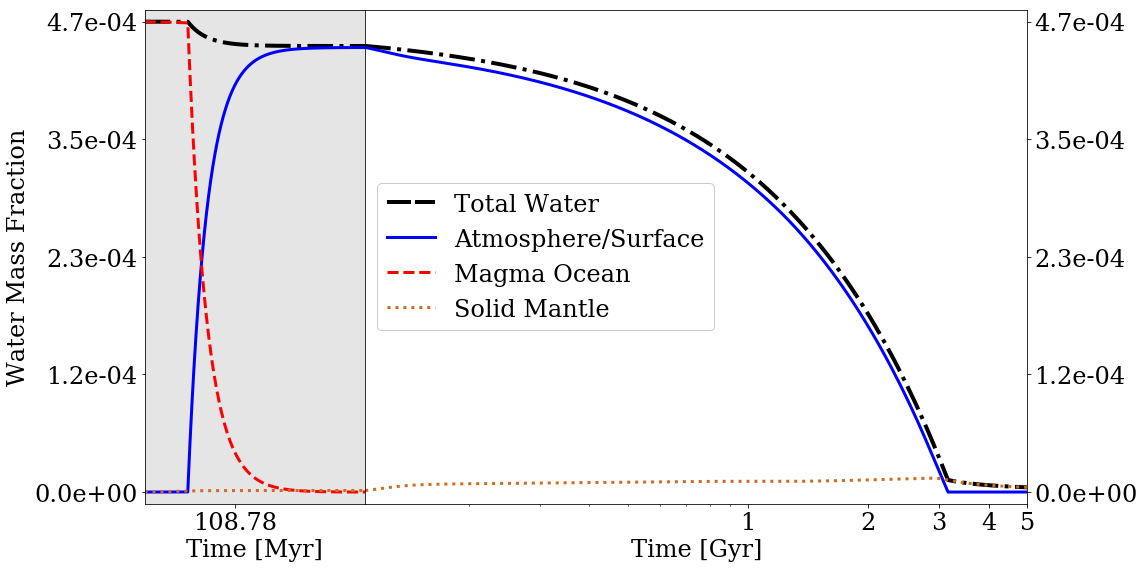

In [12]:
from matplotlib import gridspec
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
fig = plt.figure(figsize=(16,8))
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

ax1 = plt.subplot(gs[0])
# Plot time data in reverse, then flip x-axis and change the axis labels.
ax1 = plt.subplot(gs[0])
plt.plot(t_MO_array[::-1]/year/1.0e6, (M_atmo_array+M_MO_array+M_SM_array)/1.4e21, linewidth=4, linestyle='-.', color='k')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_atmo_array/1.4e21, linewidth=3, color='b', linestyle='-', label='Atmosphere')
plt.plot(t_MO_array[::-1]/year/1.0e6, (M_MO_array)/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_SM_array/1.4e21, linewidth=3, color='chocolate', linestyle=':', label='Solid Mantle')
ax1.set_xscale('log')
plt.axvspan(t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6, alpha=0.2, color='grey')
plt.xlim([t_MO_array[0]/year/1.0e6, t_MO_array[-1]/year/1.0e6])
mpscale = M/M_E #mass of planet
wmf = 1.4e21/M_E #water mass fraction of 1 Earth Ocean for 1 Earth Mass
plt.ylim([-0.05*mpscale, (2.05*mpscale)])
plt.gca().invert_xaxis()
plt.xlabel('Time [Myr]', fontsize=24)
plt.ylabel('Water Mass Fraction', fontsize=24)
## Below, for 2 TO
plt.yticks(np.array([0,0.5,1,1.5,2])*mpscale, np.round(np.array([0,0.5,1,1.5,2])*wmf, 5))
## Below, for 6 TO
#plt.yticks(np.array([0,1,2,3,4,5,6])*mpscale, np.round(np.array([0,1,2,3,4,5,6])*wmf, 5))
current_values = (plt.gca().get_yticks())*wmf/mpscale
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
#ax1.set_xticks([0.01, 1., 100.]) #comment this in/out if there is an issue
ax1.set_xticks([1.]) #comment this in/out if there is an issue
plt.gca().set_xticklabels((round(t_MO_array[-1]/year/1.0e6,2))-plt.gca().get_xticks())

ax2 = plt.subplot(gs[1])
ax2.yaxis.tick_right()
#plt.yticks(np.array([0,1,2,3,4,5,6]), np.array([0,1,2,3,4,5,6]))
## Re-colour/change linestyle if/when SURFACE becomes desiccated during cycling.
#des_surf_idx = np.where(W_s_array<1.29e16)[0][0]
#plt.semilogx(t_array[0:des_surf_idx-1]/year/1.0e9, W_s_array[0:des_surf_idx-1]/1.4e21, linewidth=3, color='b', linestyle='--', label='Atmosphere/Surface')
#plt.semilogx(t_array[des_surf_idx:]/year/1.0e9, W_s_array[des_surf_idx:]/1.4e21, linewidth=3, color='k', linestyle='-.') #, label='Desiccated')
## If surface doesn't become desiccated, just plot as-is.
plt.semilogx(t_array/year/1.0e9, (W_m_array+W_s_array)/1.4e21, linewidth=4, linestyle='-.', color='k')
plt.plot(10., 10., linewidth=4, linestyle=(0, (6, 1)), color='k', label='Total Water')
plt.semilogx(t_array/year/1.0e9, W_s_array/1.4e21, linewidth=3, color='b', linestyle='-', label='Atmosphere/Surface')
plt.plot(10., 10., linewidth=3, color='r', linestyle='--', label='Magma Ocean')
## Re-colour/change linestyle if/when MANTLE becomes desiccated during cycling.
#des_idx = np.where(W_m_array<1.29e16)[0][0]
#plt.semilogx(t_array[0:des_idx-1]/year/1.0e9, W_m_array[0:des_idx-1]/1.4e21, linewidth=3, color='chocolate', linestyle=':', label='Solid Mantle')
#plt.semilogx(t_array[des_idx:]/year/1.0e9, W_m_array[des_idx:]/1.4e21, linewidth=3, color='k', linestyle='-.', label='Desiccated Mantle')
## If mantle doesn't become desiccated, just plot as-is.
plt.semilogx(t_array/year/1.0e9, W_m_array/1.4e21, linewidth=3, color='chocolate', linestyle=':', label='Solid Mantle')

#plt.axhline(y=1.29e16/1.4e21, color='k', linestyle=':',linewidth=3, label='Desiccation Limit')
plt.xlim([t_MO_array[-1]/year/1.0e9, 5.0])
plt.ylim([-0.05*mpscale, (2.05*mpscale)]) #nominal, 6 TO case
## Below, for 2 TO
plt.yticks(np.array([0,0.5,1,1.5,2])*mpscale, np.round(np.array([0,0.5,1,1.5,2])*wmf, 5))
## Below, for 6 TO
#plt.yticks(np.array([0,1,2,3,4,5,6])*mpscale, np.round(np.array([0,1,2,3,4,5,6])*wmf, 5))current_values = (plt.gca().get_yticks())*wmf/mpscale
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:.1e}'.format(x) for x in current_values])
plt.xticks([1,2,3,4,5], [1,2,3,4,5])
#plt.ylim([-0.2, 4.2])
plt.xlabel('Time [Gyr]', fontsize=24)
plt.legend(loc='center left', fontsize=24, framealpha=1)

plt.tight_layout()
fig.subplots_adjust(wspace=0)
#plt.savefig('SuperEarths_Temporal_MO_Cycling_Loss_1MEarth_M8_2TO_MidHZ_C0d01_D0d001.pdf', bbox_inches='tight') #C_sat=0.01

## Create a grid figure to display results of ALL runs:
### Each panel = planetary mass (1, 2, 4, 8 M_Earth)
### y-axis: water mass fraction
### x-axis: HZ location (Inner, Mid, Outer)
### Points: big hollow dashed circle = initial TOTAL water in magma ocean; small solid circle = final TOTAL water, coloured based on final SURFACE water

Text(0, 0.5, 'Initial Water Mass Fraction [$M_\\mathrm{init}/M_\\mathrm{p}$]')

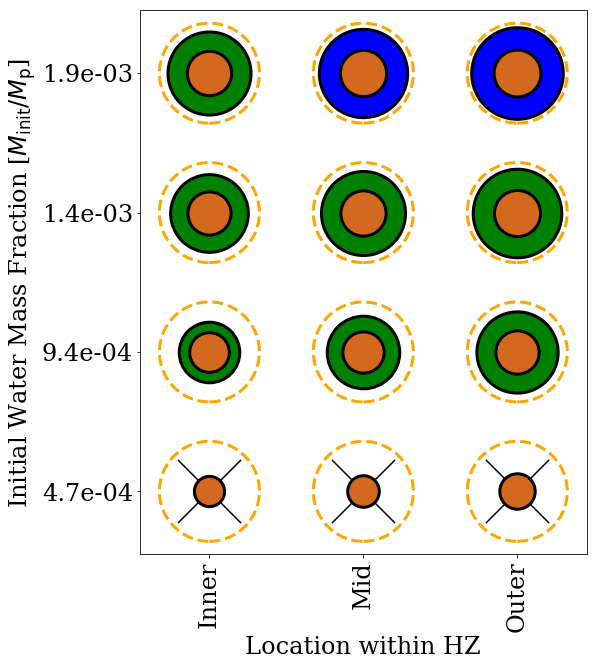

In [14]:
# If desiccated at end, black X.
# Size of circles indicate the amount of water. (bigger = more water)
# Brown circle in middle scaled for solid mantle water.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
fig = plt.figure(figsize=(8,10))
#ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()
#fig.subplots_adjust(hspace=0, wspace=0)

tolerance = 1.29e16*((M/M_E)**0.54) #anything below this, DESICCATED

# For figure to be nice and clean, need to have temporary indices, and add labels after plotting.
water_y = np.array([1,2,3,4]) #need to label [2, 4, 6, 8] Earth Oceans
HZ_x = np.array([1,2,3]) #need to label [Inner, Mid, Outer] HZ

# Combine water inventories into TOTAL initial and TOTAL final:
W_initial_total = M_MO_initial_all + M_SM_initial_all + M_atmo_initial_all
W_final_total = W_m_final_all + W_s_final_all


##################### SURFACE & MANTLE WATER #########################
for jdx in range(0,len(HZ_x)):
        
    for kdx in range(0,len(water_y)):
            
        #ax1 = plt.subplot(2,2,idx+1)

        # ALL WATER BEGINS DISSOLVED IN MAGMA OCEAN, FOR EACH SIMULATION!!!
        init_color = 'orange'
            
        # Choose marker size based on initial water. XXXX FIGURE OUT A GOOD WAY TO DO THIS XXXX
        init_size = 10000.

        # Choose corresponding colour for final values, BASED ON SURFACE WATER INVENTORY.
        if W_s_final_all[kdx,jdx] < tolerance: #no surface water
            fin_color = 'black'
            fin_mark = 'x'
        elif W_s_final_all[kdx,jdx] > tolerance and W_s_final_all[kdx,jdx] < (0.01*1.4e21)*((M/M_E)**0.54):
            fin_color = 'gold' #Dune planet
            fin_mark = 'o'
        elif W_s_final_all[kdx,jdx] >= (0.01*1.4e21)*((M/M_E)**0.54) and W_s_final_all[kdx,jdx] < (3.7*1.4e21)*((M/M_E)**0.08):
            fin_color = 'green' #habitable
            fin_mark = 'o'
        elif W_s_final_all[kdx,jdx] >= (3.7*1.4e21)*((M/M_E)**0.08):
            fin_color = 'blue' #waterworld
            fin_mark = 'o'
    
        # Choose marker size based on final TOTAL water.
        if fin_color == 'black':
            fin_size = 4000.
            lws = 5.
        else:
            fin_size = init_size*((W_final_total[kdx,jdx]/W_initial_total[kdx,jdx])**0.5)
            lws = 3.
        #Scale mantle water circle to be plotted on top.
        fin_mantle_size = init_size*((W_m_final_all[kdx,jdx]/W_initial_total[kdx,jdx])**0.5)
    
        # Plot initial and final water amounts.
        #plt.plot(HZ_x[jdx], tau_y[kdx], fillstyle='none', color=init_color, marker='o', linestyle='', markersize=init_size)
        #plt.plot(HZ_x[jdx], tau_y[kdx], fillstyle='full', color=fin_color, marker=fin_mark, linestyle='', markersize=fin_size)
        plt.scatter(HZ_x[jdx], water_y[kdx], s=fin_size, facecolors=fin_color, edgecolors='k', marker=fin_mark, linestyle='-',alpha=1, linewidths=3, zorder=3)
        plt.scatter(HZ_x[jdx], water_y[kdx], s=init_size, facecolors='none', edgecolors='orange',  linestyle='--', marker='o',alpha=1, linewidths=3, zorder=3)
        plt.scatter(HZ_x[jdx], water_y[kdx], s=fin_mantle_size, facecolors='chocolate', edgecolors='k', marker='o', linestyle='-',alpha=1, linewidths=3, zorder=3)

labels_x = ['Inner', 'Mid', 'Outer']
plt.xticks(HZ_x, labels_x, rotation='vertical', fontsize=24)
labels_y = ['4.7e-04', '9.4e-04', '1.4e-03', '1.9e-03']
plt.yticks(water_y, labels_y, fontsize=24)
plt.xlim(0.55, 3.45)
plt.ylim(0.55, 4.45)
plt.xlabel('Location within HZ', fontsize=24)
plt.ylabel(r'Initial Water Mass Fraction [$M_\mathrm{init}/M_\mathrm{p}$]', fontsize=24)
        
# Handles for legend only
#ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
#ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
#ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
#ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
#ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
#ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Model3_Grid_Parameter_Space_M8star_MO_Cycling_C0d01_D0d1_2EarthMass_Mantle.pdf', bbox_inches='tight')